# Langrange'sche Trackausschnitte

Für eine sinnvolle Analyse der HACI-Objekte brauchen wir Langrange'sche Ausschnitte der Satellitendaten. Zunächst sehen wir uns nur mal die HACI-Objekte für 2013 an.

In [175]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

from analysis_tools import grid_and_interpolation as gi
from standard_config import *

import MSGtools as mst
from l15_msevi import msevi_config

import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
sys.path.append("{}/utils".format(local_home_path))
import load_satellite_data as lsd

sys.path.append("{}/utils/tracking".format(local_home_path))
import tracking_common as tco
import optical_flow_tracking as oft

sys.path.append("{}/utils/tracking_fabian".format(local_home_path))
import cross_correlation_tracking as cct

from analysis_tools import optical_flow as oflow

from io_tools import radolan

from plotting_tools.colormaps import radar_cmap as rc
from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()
import nwcsaf_ct_cmap
ct_cmap, ct_norm, ct_names = nwcsaf_ct_cmap.nwcsaf_ct_cmap()

import geooperations as go
import fixed_colourbar as fc

import cv2

In [2]:
def get_index_kdtree(points, lat, lon):
    """
    Determine index of given points in the given coordinate arrays.
    
    Inputs:
        points: array-like, array([[lats],[lons]]), float
            points for which the indices are to be determined
        lat: array-like, float
            array of latitude coordinates 
        lon: array-like, float
            array of longitude coordinates
        
    Returns:
        indices: list with index sets of closest coordinate points to the given points    
    """
    
    from scipy.spatial import cKDTree
    import numpy as np
    
    # combine coordinate arrays into one stack
    combined_coordinate_arrays = np.dstack([lat.ravel(),lon.ravel()])[0]
    
    # transform points into a list
    points_list = list(points.transpose())
    
    # create cKDTree in which to look for the coordinates 
    tree = cKDTree(combined_coordinate_arrays)
    
    # query cKDTree
    dist, indices = tree.query(points_list)
    
    # re-transform coordinates to match starting coordinate array shapes
    results = []
    
    for idx in indices:
        results.append(np.unravel_index(idx,lon.shape))
        
    return results

## 1. HACI-Objekte laden und auswählen
Zuerst laden wir uns alle vorgefilterten HACI-Objekte für den Zeitraum 2008 bis 2017.

In [3]:
haci_objects = pd.read_csv("{}/HACI_bbox_data/haci_objects_filtered.csv".format(local_data_path))

Als nächstes wählen wir alle Objekte aus, die aus dem Jahr 2013 stammen. Dafür wandeln wir das Datum, das derzeit nur eine Zeichenkette ist in ein Format um, das Python auch als Zeitobjekt erkennt.

In [4]:
haci_objects = haci_objects.assign(date=pd.to_datetime(haci_objects['date'].astype(str) + 'T' + haci_objects['time'],utc=True))

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [5]:
haci_objects_2013 = haci_objects[(haci_objects.date >= pd.to_datetime("2013-01-01T0000",utc=True)) & 
                                 (haci_objects.date <= pd.to_datetime("2013-12-31T2359",utc=True))]

## 2. Satellitendaten laden

Nun laden wir die Satellitendaten für einen Zeitraum von <i>t</i><sub>CI</sub> &pm; 30 min.

In [6]:
slon,slat = mst.get_msg_lon_lat('eu')
hlon = gi.make_hrv_upscaling(slon)
hlat = gi.make_hrv_upscaling(slat)

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [7]:
case = haci_objects_2013.iloc[10]

Dafür erstellen wir uns für jedes HACI-Objekt eine Liste mit den nötigen Zeitschritten.

In [8]:
tlist = pd.date_range(start = case.date - pd.Timedelta("30min"),
                      end = case.date + pd.Timedelta("30min"),
                      freq = "5min")

print(tlist)

DatetimeIndex(['2013-04-18 15:20:00+00:00', '2013-04-18 15:25:00+00:00',
               '2013-04-18 15:30:00+00:00', '2013-04-18 15:35:00+00:00',
               '2013-04-18 15:40:00+00:00', '2013-04-18 15:45:00+00:00',
               '2013-04-18 15:50:00+00:00', '2013-04-18 15:55:00+00:00',
               '2013-04-18 16:00:00+00:00', '2013-04-18 16:05:00+00:00',
               '2013-04-18 16:10:00+00:00', '2013-04-18 16:15:00+00:00',
               '2013-04-18 16:20:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='5T')


Dann laden wir uns die nötigen Satellitendaten und -produkte für diese Zeitstempel.

In [9]:
satellite_fields = msevi_config._narrow_channels + ['HRV','CT','CTTH_HEIGHT','CMa']

In [10]:
sat_data = {ch:[] for ch in satellite_fields}

for i,t in enumerate(tlist):
    sat_obs = lsd.load_satellite_data_multichannel(t,channel_list = msevi_config._narrow_channels + ['HRV'])
    
    for k in ['CT','CTTH_HEIGHT','CMa']:
        sat_data[k].append(mst.get_nwcsaf_prod(k,t,calibrate=True))
        
    for k in msevi_config._narrow_channels + ['HRV']:
        if k == 'HRV':
            cth_hires = gi.make_hrv_upscaling(sat_data['CTTH_HEIGHT'][i])
            px_corr = go.parallax_correct_msg(sat_obs[k],hlon,hlat,cth_hires,'hrv','eu','rss',3)
        else:
            px_corr = go.parallax_correct_msg(sat_obs[k],slon,slat,sat_data['CTTH_HEIGHT'][i],'std','eu','rss',3)
        
        sat_data[k].append(px_corr)

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


/vols/satellite/home/lenk/lib/tropy/l15_msevi/msevi.py:659: RuntimeWarning: divide by zero encountered in true_divide
  np.log(C1 * nu_c[ch]**3./self.rad[ch] + 1) - B[ch]) / A[ch])


Region suggests use of hdf file
Region suggests use of hdf file


## 3. Bewegungsfelder

Als nächstes leiten wir Bewegungsfelder aus den Satellitendaten ab, um Ausschnitte erzeugen zu können, die sich mit dem Feld bewegen.

In [11]:
r = radolan.Radolan()

In [12]:
r.read(tlist[7].to_pydatetime())

(46, 49)

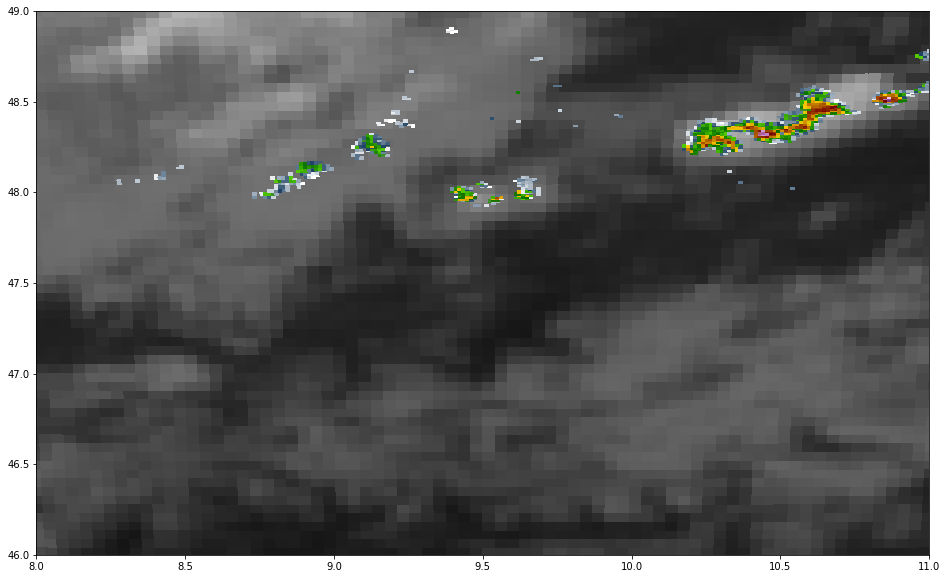

In [13]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.pcolormesh(slon,slat,sat_data['IR_108'][7],vmin=210,vmax=300,cmap='gray_r')
ax.pcolormesh(r.lon,r.lat,np.ma.masked_less(r.data,20),cmap=rc())
ax.set_xlim(8,11)
ax.set_ylim(46,49)

Das scheint so zu funktionieren. Als nächstes erzeugen wir uns einen Ausschnitt um den Punkt und ermitteln das Bewegungsfeld zum nächsten Zeitschritt.

In [14]:
def get_radar_box_from_sat(sat_row, sat_col, sat_lat, sat_lon, box_size, radar_lat, radar_lon):
    row_min = sat_row - box_size // 2
    row_max = sat_row + box_size // 2 + 1
    col_min = sat_col - box_size // 2
    col_max = sat_col + box_size // 2 + 1
    
    lon_min = sat_lon[row_min, col_min]
    lon_max = sat_lon[row_max, col_max]
    lat_max = sat_lat[row_min, col_min]
    lat_min = sat_lat[row_max, col_max]
    
    r_idx = get_index_kdtree(np.array([[lat_min,lat_max], [lon_min,lon_max]]),radar_lat, radar_lon)
    
    return r_idx

In [15]:
def cutout_box(data, row, col, box_size):
    cutout = gi.cutout_field4box(data,(row,col),box_size)
    
    return cutout

In [16]:
def cutout_radar_from_sat(data, row, col, box_size, sat_lat, sat_lon, radar_lat, radar_lon):
    r_idx = get_radar_box_from_sat(row, col, sat_lat, sat_lon, box_size, radar_lat, radar_lon)
    
    data_cutout = data[r_idx[0][0]:r_idx[1][0],r_idx[0][1]:r_idx[1][1]]
    lon_cutout = radar_lon[r_idx[0][0]:r_idx[1][0],r_idx[0][1]:r_idx[1][1]]
    lat_cutout = radar_lat[r_idx[0][0]:r_idx[1][0],r_idx[0][1]:r_idx[1][1]]
    
    return data_cutout, lon_cutout, lat_cutout

In [17]:
box_size = 51
cutouts = {k:[] for k in sat_data.keys()}

In [18]:
for k in sat_data.keys():
    data_cutout = cutout_box(sat_data[k][5],case.l0_msg_eu, case.c0_msg_eu, box_size)
    cutouts[k] = data_cutout

In [19]:
r_cutout, rlon_cutout, rlat_cutout =  cutout_radar_from_sat(r.data, case.l0_msg_eu, case.c0_msg_eu, box_size, slat, slon, r.lat, r.lon)
cutouts['RX'] = r_cutout

In [71]:
slon_cutout = cutout_box(slon, case.l0_msg_eu, case.c0_msg_eu, box_size)
slat_cutout = cutout_box(slat, case.l0_msg_eu, case.c0_msg_eu, box_size)

Text(0.5, 1.0, 'RADOLAN RX')

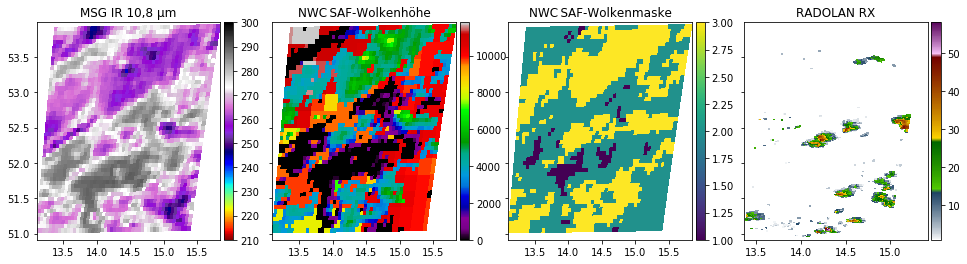

In [21]:
fig,ax = plt.subplots(1,4,figsize=(16.2,4),sharey=True)
ir_plot = ax[0].pcolormesh(slon_cutout, slat_cutout, cutouts['IR_108'],vmin=210,vmax=300,cmap=emap)
fc.colourbar(ir_plot)
ax[0].set_title(u"MSG IR 10,8 µm")
cth_plot = ax[1].pcolormesh(slon_cutout, slat_cutout,cutouts['CTTH_HEIGHT'],cmap='nipy_spectral')
fc.colourbar(cth_plot)
ax[1].set_title(u"NWC\N{THIN SPACE}SAF-Wolkenhöhe")
# ct_plot = ax[2].pcolormesh(slon_cutout, slat_cutout,cutouts['CT'],cmap=ct_cmap,norm=ct_norm)
# fc.colourbar(ct_plot)
# ax[2].set_title(u"NWC\N{THIN SPACE}SAF-Wolkentyp")
cma_plot = ax[2].pcolormesh(slon_cutout, slat_cutout,cutouts['CMa'])
fc.colourbar(cma_plot)
ax[2].set_title(u"NWC\N{THIN SPACE}SAF-Wolkenmaske")
r_plot = ax[3].pcolormesh(rlon_cutout, rlat_cutout,np.ma.masked_less(cutouts['RX'],1),cmap=rc())
fc.colourbar(r_plot)
ax[3].set_title(u"RADOLAN RX")

In [66]:
tracking_base = cutouts['IR_108']
cloud_mask = cutouts['CMa']

In [67]:
tracking_base = []

for sd in sat_data['IR_108']:
    data_cutout = cutout_box(sd,case.l0_msg_eu, case.c0_msg_eu, 51)
    tracking_base.append(data_cutout)

In [79]:
flow = oft.calculate_optical_flow_dis(tracking_base[7],tracking_base[8])

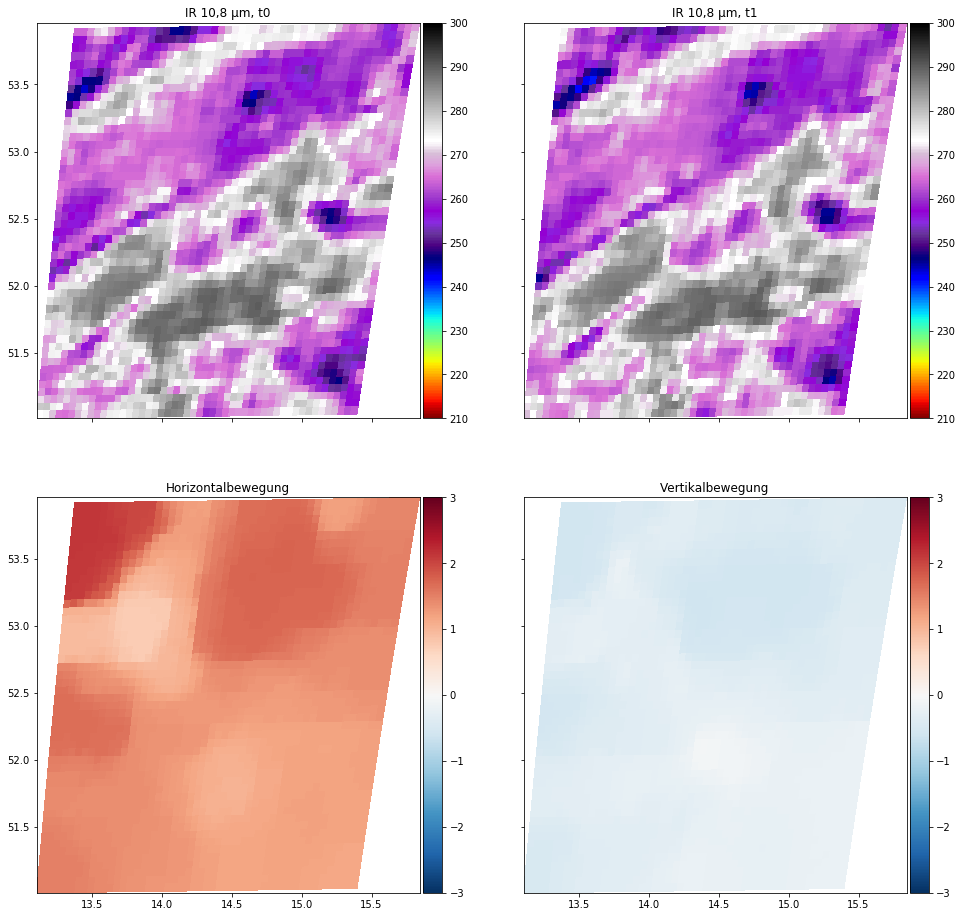

In [73]:
fig,ax = plt.subplots(2,2,figsize=(16,16),sharex=True,sharey=True)
p_plot = ax[0,0].pcolormesh(slon_cutout,slat_cutout,tracking_base[7],vmin=210,vmax=300,cmap=emap)
ax[0,0].set_title("IR 10,8 µm, t0")
fc.colourbar(p_plot)

p_plot = ax[0,1].pcolormesh(slon_cutout,slat_cutout,tracking_base[8],vmin=210,vmax=300,cmap=emap)
ax[0,1].set_title("IR 10,8 µm, t1")
fc.colourbar(p_plot)

h_plot = ax[1,0].pcolormesh(slon_cutout,slat_cutout,flow[:,:,0],vmin=-3,vmax=3,cmap='RdBu_r')
fc.colourbar(h_plot)
ax[1,0].set_title("Horizontalbewegung")
v_plot = ax[1,1].pcolormesh(slon_cutout,slat_cutout,flow[:,:,1],vmin=-3,vmax=3,cmap='RdBu_r')
ax[1,1].set_title("Vertikalbewegung")
fc.colourbar(v_plot)

Das sieht soweit vernünftig aus.

In [81]:
t0_morphed = tco.morph_field(tracking_base[7],flow[:,:,0],flow[:,:,1])

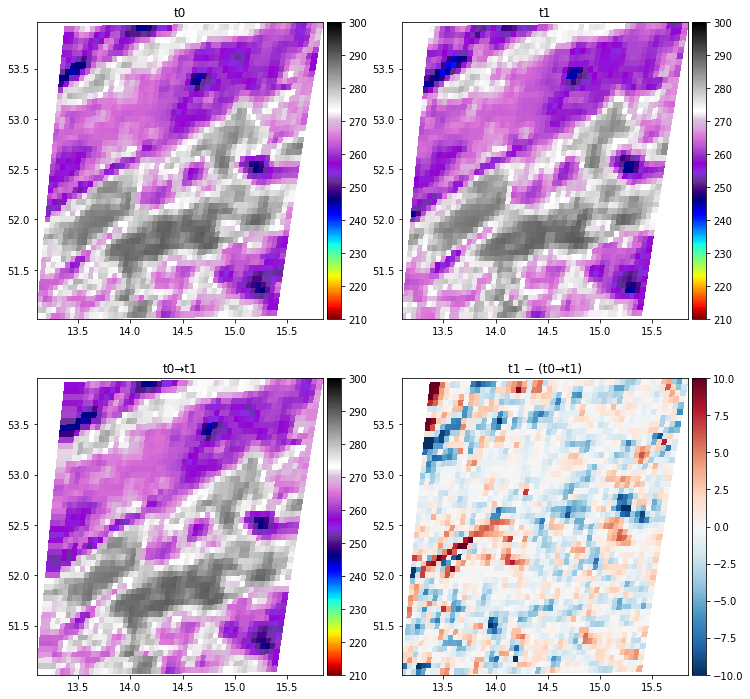

In [88]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
axs=ax.ravel()
t0p = axs[0].pcolormesh(slon_cutout,slat_cutout,tracking_base[7],vmin=210,vmax=300,cmap=emap)
axs[0].set_title("t0")
fc.colourbar(t0p)
t1p = axs[1].pcolormesh(slon_cutout,slat_cutout,tracking_base[8],vmin=210,vmax=300,cmap=emap)
axs[1].set_title("t1")
fc.colourbar(t1p)
mp = axs[2].pcolormesh(slon_cutout,slat_cutout,t0_morphed,vmin=210,vmax=300,cmap=emap)
axs[2].set_title("t0→t1")
fc.colourbar(mp)
dp = axs[3].pcolormesh(slon_cutout,slat_cutout,tracking_base[8]-t0_morphed,vmin=-10,vmax=10,cmap='RdBu_r')
axs[3].set_title("t1 − (t0→t1)")
fc.colourbar(dp)

In [89]:
from importlib import reload

In [117]:
track = tco.calculate_track(np.array(sat_data['IR_108']),(6,case.l0_msg_eu,case.c0_msg_eu),'dis',51)

In [121]:
track = track.assign(time=[t.strftime("%Y%m%d_%H%M") for t in tlist])

In [122]:
track

time_step   row_index  column_index           time
0         -30  142.750605    596.165098  20130418_1520
1         -25  142.339762    597.444912  20130418_1525
2         -20  142.134080    598.758149  20130418_1530
3         -15  141.848656    600.046255  20130418_1535
4         -10  141.649768    601.293096  20130418_1540
5          -5  141.305648    602.637469  20130418_1545
6           0  141.000000    604.000000  20130418_1550
7           5  140.703745    605.321552  20130418_1555
8          10  140.441701    606.774987  20130418_1600
9          15  140.151602    608.097881  20130418_1605
10         20  139.837429    609.479264  20130418_1610
11         25  139.572512    610.823186  20130418_1615
12         30  139.344058    612.048241  20130418_1620

In [129]:
track.iloc[0].row_index

142.7506052851677

In [231]:
tlist = pd.date_range(start = case.date - pd.Timedelta("30min"),
                          end = case.date + pd.Timedelta("30min"),
                          freq = "5min")

# Blitzdichte laden
linet_grid = xr.open_dataset("{}/data/linet_grid/linet_radolan_grid_{}.nc".format(local_home_path,tlist[0].strftime("%Y%m%d")))

# damit können wir jetzt alle Daten ausschneiden
cutouts = {ch:[] for ch in satellite_fields+['slon','slat','hlon','hlat','rx','rlon','rlat','flash_density']}

for i,t in enumerate(tlist):
    prod_data = {c:[] for c in ['CT','CTTH_HEIGHT','CMa']}

    track_row = int(np.rint(track.iloc[i].row_index))
    track_col = int(np.rint(track.iloc[i].column_index))

    sat_obs = lsd.load_satellite_data_multichannel(t.to_pydatetime(),
                                                   channel_list = msevi_config._narrow_channels + ['HRV'])

    for k in ['CT','CTTH_HEIGHT','CMa']:
        prod_data[k] = mst.get_nwcsaf_prod(k,t.to_pydatetime(),calibrate=True)

    for k in msevi_config._narrow_channels + ['HRV']:
        if k == 'HRV':
            cth_hires = gi.make_hrv_upscaling(prod_data['CTTH_HEIGHT'])
            px_corr = go.parallax_correct_msg(sat_obs[k],hlon,hlat,cth_hires,'hrv','eu','rss',3)
            fac = 3
            cutouts[k].append(cutout_box(px_corr,track_row*fac,track_col*fac,box_size*fac))
        else:
            px_corr = go.parallax_correct_msg(sat_obs[k],slon,slat,prod_data['CTTH_HEIGHT'],'std','eu','rss',3)
            fac = 1

            cutouts[k].append(cutout_box(px_corr,track_row*fac,track_col*fac,box_size*fac))

    # Satellitenkoordinaten
    cutouts['slon'].append(cutout_box(slon,track_row,track_col,box_size))
    cutouts['slat'].append(cutout_box(slat,track_row,track_col,box_size))

    cutouts['hlon'].append(cutout_box(hlon,track_row*3,track_col*3,box_size*3))
    cutouts['hlat'].append(cutout_box(hlat,track_row*3,track_col*3,box_size*3))

    for prd in prod_data:
        cutouts[prd].append(cutout_box(prod_data[prd],track_row,track_col,box_size))       

    # Radardaten
    r.read(t.to_pydatetime())
    radar_box = get_radar_box_from_sat(case.l0_msg_eu,case.c0_msg_eu,slon,slat,51,r.lon,r.lat)

    cutouts['rx'].append(r.data[radar_box[1][0]:radar_box[1][1],radar_box[0][0]:radar_box[0][1]].data)
    cutouts['rlon'].append(r.lon[radar_box[1][0]:radar_box[1][1],radar_box[0][0]:radar_box[0][1]])
    cutouts['rlat'].append(r.lat[radar_box[1][0]:radar_box[1][1],radar_box[0][0]:radar_box[0][1]])

    # Linetdaten
    itime = int((int(t.strftime("%H"))*60 + int(t.strftime("%M"))) / 5)

    flash_density = linet_grid.flash_density[itime].data
    cutouts['flash_density'].append(flash_density[radar_box[1][0]:radar_box[1][1],radar_box[0][0]:radar_box[0][1]])

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


/vols/satellite/home/lenk/lib/tropy/l15_msevi/msevi.py:659: RuntimeWarning: divide by zero encountered in true_divide
  np.log(C1 * nu_c[ch]**3./self.rad[ch] + 1) - B[ch]) / A[ch])


Region suggests use of hdf file
Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: No contour levels were found within the data range.
  


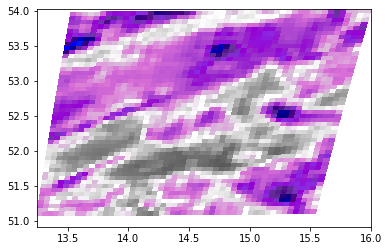

In [233]:
plt.pcolormesh(cutouts['slon'][8],cutouts['slat'][8],cutouts['IR_108'][8],vmin=210,vmax=300,cmap=emap)
plt.contour(cutouts['rlon'][8],cutouts['rlat'][8],cutouts['flash_density'][8])

In [ ]:
# linet_grid = xr.open_dataset("{}/data/linet_grid/linet_radolan_grid_{}.nc".format(local_home_path,tlist[0].strftime("%Y%m%d")))


In [182]:
linet_grid

<xarray.Dataset>
Dimensions:        (time: 288, x: 900, y: 900)
Coordinates:
  * time           (time) datetime64[ns] 2013-04-18 ... 2013-04-18T23:55:00
    lon            (x, y) float64 ...
    lat            (x, y) float64 ...
Dimensions without coordinates: x, y
Data variables:
    flash_density  (time, x, y) float32 ...
    mean_current   (time, x, y) float32 ...
    max_current    (time, x, y) float32 ...
Attributes:
    title:               Gridded Linet data on RADOLAN RX grid for 20130418.
    institution:         Leibniz Institute for Tropospheric Research
    contact_person:      Stephan Lenk, lenk@tropos.de
    processing_time:     20190916T14:44:54
    author:              Stephan Lenk, lenk@tropos.de
    license:             For non-commercial use only.
    source:              Linet lightning detection network data
    history:             Gridded and aggregated for 5 min time steps from the...
    summary:             Linet data aggregated for 5 minutes on the RADOLAN R.

In [251]:
def write2netcdf(case_data,cutout_data):
    target_path = "{}/proj/2019-01_trackingstudie/data/lagrangian_tracks/field_data".format(local_home_path)

    track_id = "{}_{}".format(case_data.date.strftime("%Y%m%d"), case_data.id)

    time_data = pd.date_range(start = case.date - pd.Timedelta("30min"),
                              end = case.date + pd.Timedelta("30min"),
                              freq = "5min")

    filename = "{}/haci_trackdata_{}.nc".format(target_path,track_id)

    ds = xr.Dataset({'vis006': (['time','sx', 'sy'],  cutout_data['VIS006']),
                     'vis008': (['time','sx', 'sy'],  cutout_data['VIS008']),
                     'ir016': (['time','sx', 'sy'],  cutout_data['IR_016']),
                     'ir039': (['time','sx', 'sy'],  cutout_data['IR_039']),
                     'wv062': (['time','sx', 'sy'],  cutout_data['WV_062']),
                     'wv073': (['time','sx', 'sy'],  cutout_data['WV_073']),
                     'ir087': (['time','sx', 'sy'],  cutout_data['IR_087']),
                     'ir097': (['time','sx', 'sy'],  cutout_data['IR_097']),
                     'ir108': (['time','sx', 'sy'],  cutout_data['IR_108']),
                     'ir120': (['time','sx', 'sy'],  cutout_data['IR_120']),
                     'ir134': (['time','sx', 'sy'],  cutout_data['IR_134']),
                     'hrv': (['time','hx', 'hy'],  cutout_data['HRV']),
                     'ct': (['time','sx', 'sy'],  cutout_data['CT']),
                     'ctth': (['time','sx', 'sy'],  cutout_data['CTTH_HEIGHT']),
                     'cma': (['time','sx', 'sy'],  cutout_data['CMa']),
                     'rx': (['time','rax', 'ray'],  cutout_data['rx']),
                     'flash_density': (['time','rax', 'ray'],  cutout_data['flash_density'])},
                     
                     coords={'time': time_data,
                             'slon': (['time','sx', 'sy'], cutout_data['slon']),
                             'slat': (['time','sx', 'sy'], cutout_data['slat']),
                             'hlon': (['time','hx', 'hy'], cutout_data['hlon']),
                             'hlat': (['time','hx', 'hy'], cutout_data['hlat']),
                             'rlon': (['time','rax', 'ray'], cutout_data['rlon']),
                             'rlat': (['time','rax', 'ray'], cutout_data['rlat'])})
    
    ds.attrs['title'] = "Collection of MSG, RADOLAN and Linet data for HACI track {}.".format(track_id)
    ds.attrs['institution'] = "Leibniz Institute for Tropospheric Research"
    ds.attrs['contact_person'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['processing_time'] = pd.Timestamp.now().strftime("%Y%m%dT%H:%M:%S")
    ds.attrs['author'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['license'] = "For non-commercial use only."
    ds.attrs['source'] = "MSG SEVIRI data, RADOLAN RX data, gridded Linet data"
    ds.attrs['history'] = "Gridded and aggregated for 5 min time steps from the original data."
    ds.attrs['summary'] = "Lagrangian data stack for the HACI track {} in a cutout of 51px x 51px around the track points.".format(track_id)
    ds.attrs['region_id'] = "RADOLAN RX"
    ds.attrs['spatial_resolution'] = "3 km x 6km, 1 km x 1 km"
    ds.attrs['gdal_projection'] = u'+proj=stere +lat_0=90 +lat_ts=60 +lon_0=10 ' +\
                                 u'+x_0=0 +y_0=0 +a=6370.040 +b=6370.040 +units=km'

    ds.vis006.attrs['units'] = "1"
    ds.vis006.attrs['summary'] = 'BDRF of MSG SEVIRI channel VIS 006'
    ds.vis008.attrs['units'] = "1"
    ds.vis008.attrs['summary'] = 'BDRF of MSG SEVIRI channel VIS 008'
    ds.ir016.attrs['units'] = "1"
    ds.ir016.attrs['summary'] = 'BDRF of MSG SEVIRI channel IR 016'
    ds.ir039.attrs['units'] = "K"
    ds.ir039.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 039'
    ds.wv062.attrs['units'] = "K"
    ds.wv062.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel WV 062'
    ds.wv073.attrs['units'] = "K"
    ds.wv073.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel WV 073'
    ds.ir087.attrs['units'] = "K"
    ds.ir087.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 087'
    ds.ir097.attrs['units'] = "K"
    ds.ir097.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 097'
    ds.ir108.attrs['units'] = "K"
    ds.ir108.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 108'
    ds.ir120.attrs['units'] = "K"
    ds.ir120.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 120'
    ds.ir134.attrs['units'] = "K"
    ds.ir134.attrs['summary'] = 'Brightness temperature of MSG SEVIRI channel IR 134'
    ds.ct.attrs['units'] = "1"
    ds.ct.attrs['summary'] = 'NWCSAF v2013 cloud type'
    ds.cma.attrs['units'] = "1"
    ds.cma.attrs['summary'] = 'NWCSAF v2013 cloud mask'
    ds.ctth.attrs['units'] = "m"
    ds.ctth.attrs['summary'] = 'NWCSAF v2013 cloud top height'
    ds.rx.attrs['units'] = "dBZ"
    ds.rx.attrs['summary'] = 'RADOLAN RX product'
    ds.flash_density.attrs['units'] = 'fl/kilometer^2'
    ds.flash_density.attrs['summary'] = 'Flash density per RADOLAN RX grid cell derived from Linet data'

    encoding = {'vis006':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'vis008':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ir016':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ir039':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'wv062':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'wv073':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ir087':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ir097':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ir108':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ir120':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ir134':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999},
                'ct':{'complevel':9,'zlib':True,'dtype':'int16','_FillValue':-999},
                'cma':{'complevel':9,'zlib':True,'dtype':'int16','_FillValue':-999},
                'ctth':{'complevel':9,'zlib':True,'dtype':'int16','_FillValue':-999},
                'rx':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10,'_FillValue':-999},
                'flash_density':{'complevel':9,'zlib':True,'dtype':'int16','scale_factor':10000,'_FillValue':-999}}

    ds.to_netcdf(filename,encoding=encoding)

    nachricht = "Daten unter %s gespeichert.\n" % filename
    print(nachricht)
    return

In [252]:
write2netcdf(case,cutouts)

Daten unter /vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/lagrangian_tracks/field_data/haci_trackdata_20130418_1071.nc gespeichert.



In [255]:
track_id = "{}_{}".format(case.date.strftime("%Y%m%d"), case.id)

In [257]:
track.to_csv("{}/proj/2019-01_trackingstudie/data/lagrangian_tracks/track_data/track_{}.csv".format(local_home_path,track_id),index=False,float_format="%.2f")

In [125]:
radar_cutouts = []

for t in tlist:
    r.read(t.to_pydatetime())
    
    cutout = r.data[case.l0:case.l1,case.c0:case.c1]
    
    radar_cutouts.append(cutout)

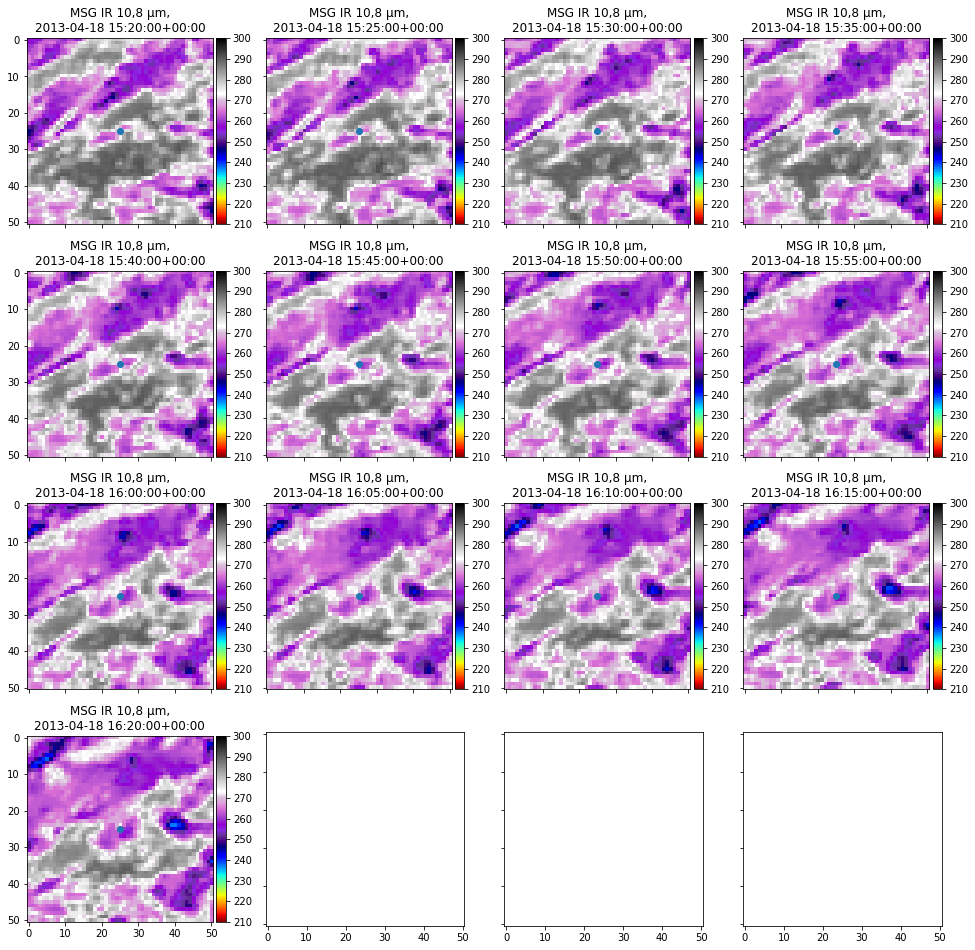

In [124]:
fig,ax = plt.subplots(4,4,figsize=(16.4,16.4),sharex=True,sharey=True)
axs= ax.ravel()
for i, cutout in enumerate(track_cutouts):
    c_plot = axs[i].imshow(cutout,vmin=210,vmax=300,cmap=emap)
    axs[i].plot(51//2, 51//2,'o')
    axs[i].set_title(u"MSG IR 10,8 µm,\n{}".format(tlist[i]))
    fc.colourbar(c_plot)

Endlich funktioniert es! Der DIS-Fluss verfolgt das Feld ganz gut.

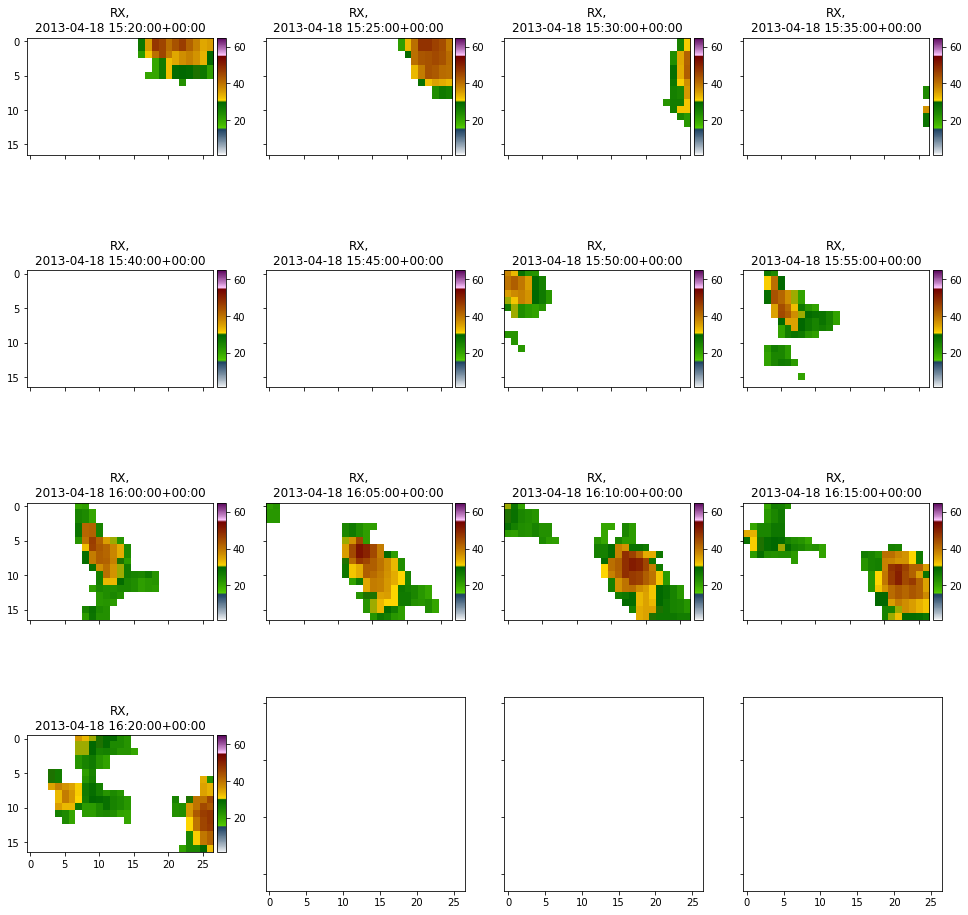

In [126]:
fig,ax = plt.subplots(4,4,figsize=(16.4,16.4),sharex=True,sharey=True)
axs= ax.ravel()
for i, cutout in enumerate(radar_cutouts):
    c_plot = axs[i].imshow(np.ma.masked_less(cutout,20),vmin=1,vmax=65,cmap=rc())
    axs[i].set_title(u"RX,\n{}".format(tlist[i]))
    fc.colourbar(c_plot)

In [51]:
cloudiness = dict()

for i, case in haci_objects.iterrows():
    centroid_row  = case.l00_msg_eu + (case.l01_msg_eu - case.l00_msg_eu) // 2
    centroid_col  = case.c00_msg_eu + (case.c01_msg_eu - case.c00_msg_eu) // 2


    try:
        cma = mst.get_nwcsaf_prod("CMa",case.date.to_pydatetime())
        cutout = gi.cutout_field4box(cma[0],(start_row,start_col),51)

        cloud_fraction = len(np.where(cutout >= 2)[0]) / float(cutout.shape[0]*cutout.shape[1])

        case_id = "{}_{}".format(case.date,case.id)
        cloudiness[case_id] = cloud_fraction
    except:
         continue

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/01/07/SAFNWC_MSG?_CMa__200801070945_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/01/17/SAFNWC_MSG?_CMa__200801171730_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/01/22/SAFNWC_MSG?_CMa__200801220555_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/02/06/SAFNWC_MSG?_CMa__200802060340_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/02/06/SAFNWC_MSG?_CMa__200802061305_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/03/01/SAFNWC_MSG?_CMa__200803010725_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/03/04/SAFNWC_MSG?_CMa__200803041800_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/09/02/SAFNWC_MSG?_CMa__200809022010_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/09/03/SAFNWC_MSG?_CMa__200809031250_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/09/03/SAFNWC_MSG?_CMa__200809031445_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/09/03/SAFNWC_MSG?_CMa__200809031545_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/09/03/SAFNWC_MSG?_CMa__200809031620_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/09/03/SAFNWC_MSG?_CMa__200809031655_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2008/09/03/SAFNWC_MSG?_CMa__200809031710_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2009/11/23/SAFNWC_MSG?_CMa__200911231230_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2009/11/24/SAFNWC_MSG?_CMa__200911240435_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2010/06/25/SAFNWC_MSG?_CMa__201006251425_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2010/06/29/SAFNWC_MSG?_CMa__201006291450_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2010/06/29/SAFNWC_MSG?_CMa__201006291455_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2010/06/30/SAFNWC_MSG?_CMa__201006301035_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2010/06/30/SAFNWC_MSG?_CMa__201006301220_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2011/04/30/SAFNWC_MSG?_CMa__201104301435_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2011/04/30/SAFNWC_MSG?_CMa__201104301605_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2011/06/28/SAFNWC_MSG?_CMa__201106281725_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2011/06/28/SAFNWC_MSG?_CMa__201106281845_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2011/06/28/SAFNWC_MSG?_CMa__201106281920_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2011/06/28/SAFNWC_MSG?_CMa__201106281935_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2011/06/28/SAFNWC_MSG?_CMa__201106282105_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/04/04/SAFNWC_MSG?_CMa__201204040245_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/05/02/SAFNWC_MSG?_CMa__201205021155_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/05/02/SAFNWC_MSG?_CMa__201205021230_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/05/02/SAFNWC_MSG?_CMa__201205021235_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/05/02/SAFNWC_MSG?_CMa__201205021305_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/05/02/SAFNWC_MSG?_CMa__201205021335_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/05/02/SAFNWC_MSG?_CMa__201205021340_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/09/18/SAFNWC_MSG?_CMa__201209181710_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/09/18/SAFNWC_MSG?_CMa__201209181710_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/09/18/SAFNWC_MSG?_CMa__201209181815_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/09/18/SAFNWC_MSG?_CMa__201209181830_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/09/19/SAFNWC_MSG?_CMa__201209191855_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2012/09/19/SAFNWC_MSG?_CMa__201209192045_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/01/31/SAFNWC_MSG?_CMa__201301311510_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/03/SAFNWC_MSG?_CMa__201606031240_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/03/SAFNWC_MSG?_CMa__201606031250_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/03/SAFNWC_MSG?_CMa__201606031505_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/03/SAFNWC_MSG?_CMa__201606031520_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/03/SAFNWC_MSG?_CMa__201606031600_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/03/SAFNWC_MSG?_CMa__201606031610_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/03/SAFNWC_MSG?_CMa__201606031725_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251635_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251635_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251640_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251700_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251720_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251740_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251820_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251040_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251225_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251320_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251425_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251505_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251515_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251620_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281640_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281640_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281640_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281645_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281645_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281655_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281700_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301340_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301340_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301350_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301405_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301410_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301420_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301420_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/22/SAFNWC_MSG?_CMa__201706221750_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/22/SAFNWC_MSG?_CMa__201706221755_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/22/SAFNWC_MSG?_CMa__201706221820_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/22/SAFNWC_MSG?_CMa__201706221820_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/22/SAFNWC_MSG?_CMa__201706221820_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/22/SAFNWC_MSG?_CMa__201706221920_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/22/SAFNWC_MSG?_CMa__201706221950_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/08/SAFNWC_MSG?_CMa__201707081955_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/08/SAFNWC_MSG?_CMa__201707082005_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/08/SAFNWC_MSG?_CMa__201707082005_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/08/SAFNWC_MSG?_CMa__201707082005_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/09/SAFNWC_MSG?_CMa__201707090115_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/09/SAFNWC_MSG?_CMa__201707090325_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/09/SAFNWC_MSG?_CMa__201707090415_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707201720_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707201720_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707201905_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707201905_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707201910_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707202135_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/21/SAFNWC_MSG?_CMa__201707211500_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/08/SAFNWC_MSG?_CMa__201708081715_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/08/SAFNWC_MSG?_CMa__201708081755_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/08/SAFNWC_MSG?_CMa__201708081900_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/08/SAFNWC_MSG?_CMa__201708081930_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/09/SAFNWC_MSG?_CMa__201708091855_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/09/SAFNWC_MSG?_CMa__201708091950_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/09/SAFNWC_MSG?_CMa__201708092155_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumc

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/12/13/SAFNWC_MSG?_CMa__201712132125_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/12/13/SAFNWC_MSG?_CMa__201712132130_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/12/14/SAFNWC_MSG?_CMa__201712140335_rss-eu______.c?.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/12/14/SAFNWC_MSG?_CMa__201712140655_rss-eu______.c?.h5  does not exist!


In [53]:
len(cloudiness.keys())

5918

## Einteilung der Fälle

Leider ist in einem Großteil der Fälle der Bedeckungsgrad zu hoch, um eine vernünftiges Bewegungsfeld abzuleiten. Jamal & Kleisl (2018) habne einen interessanten Ansatz, um Fälle zu finden, die sich verfolgen lassen. Dazu wird zuerst die räumliche Varianz eiener Größe (hier Helligkeitstemperatur) über bestimmt und dann der Bedeckungsgrad.

### 1 Räumliche Varianz

Jamal & Kleisl (2018) definieren in ihrer Studie die räumliche Varainz des Klarenhimmelindex K<sub>t</sub>:

<i>var</i><sub>s</sub> = 1 - (MW(K<sub>t,s</sub>) / (max(K<sub>t,s</sub>)).

Da hier die Größen dafür fehlen, wäre es einen Vesuch wert, diese Varianz mit der Zeitreihe des NWC&thinsp;FSAF-Wolkenmaske in Nachbarschaft des Starzeitpunktes zu berechnen.
    
Danach erfolgt eine Einteilung der Fälle anhand des Bedeckungsgrades.

In [54]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Fortschritt: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [55]:
spatial_variance = {}
ch = 'HRV'

for i,case in haci_objects.iterrows():
    try:
        start_time = case.date
        case_id = "{}_{}".format(case.date,case.id)

        time_list = pd.date_range(start=start_time - pd.Timedelta('30min'),
                                  end=start_time + pd.Timedelta('30min'),
                                  freq='5min')
        cloudiness_list =[]
        for t in time_list:
            cma = mst.get_nwcsaf_prod('CMa',t.to_pydatetime(),calibrate=True)

            cutout = cutout_box(cma,case.l0_msg_eu, case.c0_msg_eu, 51)

            cloudiness_list.append(len(np.where(cutout >= 2)[0]) / float(cutout.shape[0]*cutout.shape[1]))

        var = 1 - (np.mean(np.array(cloudiness_list)) / np.max(np.array(cloudiness_list)))

        spatial_variance[case_id] = var

        update_progress(i / len(haci_objects))
        #print("{fortschritt:8.2f}% fertig".format(fortschritt = 100*(i / len(haci_objects))))
    except Exception as e:
        print("FEHLER {fehler} bei Fall {cid}.".format(fehler=e,cid=case_id))

Fortschritt: [###############-----] 75.8%
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2015/11/22/SAFNWC_MSG?_CMa__201511220200_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2015-11-22 02:30:00+00:00_125.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/02/08/SAFNWC_MSG?_CMa__201602080605_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-02-08 06:35:00+00:00_421.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/02/08/SAFNWC_MSG?_CMa__201602080815_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-02-08 08:45:00+00:00_636.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/02/09/SAFNWC_MSG?_CMa__201602091010_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-02-09 10:40:00+00:00_465.
ERROR:  /v

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/05/28/SAFNWC_MSG?_CMa__201605281225_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-05-28 12:55:00+00:00_724.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/05/28/SAFNWC_MSG?_CMa__201605281355_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-05-28 14:25:00+00:00_858.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/05/28/SAFNWC_MSG?_CMa__201605281405_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-05-28 14:35:00+00:00_871.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/05/28/SAFNWC_MSG?_CMa__201605281410_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-05-28 14:40:00+00:00_877.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_n

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/02/SAFNWC_MSG?_CMa__201606020345_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-02 04:15:00+00:00_326.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/02/SAFNWC_MSG?_CMa__201606020445_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-02 05:15:00+00:00_394.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/02/SAFNWC_MSG?_CMa__201606020525_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-02 05:55:00+00:00_418.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/02/SAFNWC_MSG?_CMa__201606020525_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-02 05:55:00+00:00_421.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_n

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/15/SAFNWC_MSG?_CMa__201606151340_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-15 14:10:00+00:00_1861.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/15/SAFNWC_MSG?_CMa__201606151350_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-15 14:20:00+00:00_1891.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/15/SAFNWC_MSG?_CMa__201606151410_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-15 14:40:00+00:00_1942.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/15/SAFNWC_MSG?_CMa__201606151525_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-15 15:55:00+00:00_2134.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251215_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-25 12:45:00+00:00_1291.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251245_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-25 13:15:00+00:00_1388.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251245_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-25 13:15:00+00:00_1389.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/06/25/SAFNWC_MSG?_CMa__201606251255_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-06-25 13:25:00+00:00_1427.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/11/SAFNWC_MSG?_CMa__201607111610_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-11 16:40:00+00:00_579.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/11/SAFNWC_MSG?_CMa__201607111610_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-11 16:40:00+00:00_582.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/11/SAFNWC_MSG?_CMa__201607111630_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-11 17:00:00+00:00_606.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/11/SAFNWC_MSG?_CMa__201607111645_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-11 17:15:00+00:00_616.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_n

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251250_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-25 13:20:00+00:00_1017.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251355_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-25 14:25:00+00:00_1171.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251435_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-25 15:05:00+00:00_1262.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/07/25/SAFNWC_MSG?_CMa__201607251445_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-07-25 15:15:00+00:00_1288.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/10/SAFNWC_MSG?_CMa__201608101915_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-10 19:45:00+00:00_2911.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/10/SAFNWC_MSG?_CMa__201608101945_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-10 20:15:00+00:00_2939.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/15/SAFNWC_MSG?_CMa__201608150825_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-15 08:55:00+00:00_183.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/15/SAFNWC_MSG?_CMa__201608151130_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-15 12:00:00+00:00_232.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281845_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-28 19:15:00+00:00_1505.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281845_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-28 19:15:00+00:00_1509.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281850_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-28 19:20:00+00:00_1519.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2016/08/28/SAFNWC_MSG?_CMa__201608281910_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2016-08-28 19:40:00+00:00_1554.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/18/SAFNWC_MSG?_CMa__201705182055_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-18 21:25:00+00:00_935.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/19/SAFNWC_MSG?_CMa__201705190300_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-19 03:30:00+00:00_183.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/19/SAFNWC_MSG?_CMa__201705190350_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-19 04:20:00+00:00_246.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/19/SAFNWC_MSG?_CMa__201705191310_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-19 13:40:00+00:00_1132.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301610_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-30 16:40:00+00:00_1447.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301625_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-30 16:55:00+00:00_1477.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301630_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-30 17:00:00+00:00_1483.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/05/30/SAFNWC_MSG?_CMa__201705301820_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-05-30 18:50:00+00:00_1635.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/15/SAFNWC_MSG?_CMa__201706151425_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-15 14:55:00+00:00_483.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/15/SAFNWC_MSG?_CMa__201706151440_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-15 15:10:00+00:00_499.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/15/SAFNWC_MSG?_CMa__201706151440_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-15 15:10:00+00:00_505.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/15/SAFNWC_MSG?_CMa__201706151440_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-15 15:10:00+00:00_508.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_n

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/27/SAFNWC_MSG?_CMa__201706271410_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-27 14:40:00+00:00_820.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/27/SAFNWC_MSG?_CMa__201706271500_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-27 15:30:00+00:00_864.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/27/SAFNWC_MSG?_CMa__201706271530_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-27 16:00:00+00:00_885.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/06/27/SAFNWC_MSG?_CMa__201706271655_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-06-27 17:25:00+00:00_961.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_n

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/07/SAFNWC_MSG?_CMa__201707071455_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-07 15:25:00+00:00_1641.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/07/SAFNWC_MSG?_CMa__201707071500_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-07 15:30:00+00:00_1647.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/07/SAFNWC_MSG?_CMa__201707071500_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-07 15:30:00+00:00_1649.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/07/SAFNWC_MSG?_CMa__201707071510_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-07 15:40:00+00:00_1662.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/10/SAFNWC_MSG?_CMa__201707101405_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-10 14:35:00+00:00_1771.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/10/SAFNWC_MSG?_CMa__201707101415_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-10 14:45:00+00:00_1794.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/10/SAFNWC_MSG?_CMa__201707101435_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-10 15:05:00+00:00_1837.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/10/SAFNWC_MSG?_CMa__201707101510_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-10 15:40:00+00:00_1923.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707200510_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-20 05:40:00+00:00_692.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707200800_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-20 08:30:00+00:00_922.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707200850_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-20 09:20:00+00:00_997.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/20/SAFNWC_MSG?_CMa__201707201030_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-20 11:00:00+00:00_1140.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/27/SAFNWC_MSG?_CMa__201707271650_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-27 17:20:00+00:00_848.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/27/SAFNWC_MSG?_CMa__201707271715_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-27 17:45:00+00:00_895.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/27/SAFNWC_MSG?_CMa__201707271735_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-27 18:05:00+00:00_939.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/07/27/SAFNWC_MSG?_CMa__201707271810_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-07-27 18:40:00+00:00_1000.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/03/SAFNWC_MSG?_CMa__201708030840_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-03 09:10:00+00:00_1346.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/03/SAFNWC_MSG?_CMa__201708031135_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-03 12:05:00+00:00_1702.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/03/SAFNWC_MSG?_CMa__201708031350_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-03 14:20:00+00:00_1901.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/03/SAFNWC_MSG?_CMa__201708031420_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-03 14:50:00+00:00_1946.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/24/SAFNWC_MSG?_CMa__201708240420_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-24 04:50:00+00:00_221.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/24/SAFNWC_MSG?_CMa__201708240500_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-24 05:30:00+00:00_261.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/24/SAFNWC_MSG?_CMa__201708240500_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-24 05:30:00+00:00_263.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/08/24/SAFNWC_MSG?_CMa__201708240540_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-08-24 06:10:00+00:00_294.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_n

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/10/21/SAFNWC_MSG?_CMa__201710212030_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-10-21 21:00:00+00:00_1684.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/10/29/SAFNWC_MSG?_CMa__201710290745_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-10-29 08:15:00+00:00_2126.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/11/12/SAFNWC_MSG?_CMa__201711121340_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-11-12 14:10:00+00:00_1576.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2017/11/18/SAFNWC_MSG?_CMa__201711182005_rss-eu______.c?.h5  does not exist!
FEHLER local variable 'ncols' referenced before assignment bei Fall 2017-11-18 20:35:00+00:00_645.
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l

In [150]:
spatial_variance

{'2008-05-11 17:00:00+00:00_1888': 0.023292523292523182,
 '2008-05-11 17:15:00+00:00_1912': 0.03279052084653411,
 '2008-05-26 07:35:00+00:00_786': 0.00032531866441898316,
 '2008-05-26 17:20:00+00:00_1887': 0.0018075145193788833,
 '2008-05-28 13:20:00+00:00_1037': 0.010649462896654027,
 '2008-05-28 15:00:00+00:00_1242': 0.015067406819984419,
 '2008-05-28 22:15:00+00:00_1947': 0.027034731790753885,
 '2008-05-29 01:35:00+00:00_137': 0.00011829769615245844,
 '2008-05-29 03:50:00+00:00_408': 0.0,
 '2008-05-29 05:45:00+00:00_679': 0.0,
 '2008-05-29 06:15:00+00:00_764': 0.0,
 '2008-05-29 14:50:00+00:00_1870': 0.014221579438970733,
 '2008-05-29 15:40:00+00:00_1958': 0.010858654986768856,
 '2008-05-29 19:55:00+00:00_2372': 0.0922183268027772,
 '2008-05-30 06:40:00+00:00_748': 0.010720556976063556,
 '2008-05-30 12:25:00+00:00_1321': 0.06479265057902583,
 '2008-05-30 12:25:00+00:00_1323': 0.069816575434553,
 '2008-05-30 12:35:00+00:00_1343': 0.011816886816886862,
 '2008-05-30 15:05:00+00:00_1638'

In [168]:
sp_var = []
cl = []
for k in list(spatial_variance.keys()):
    sv = spatial_variance[k]
    c = cloudiness[k]
    
    sp_var.append(sv)
    cl.append(c)   

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

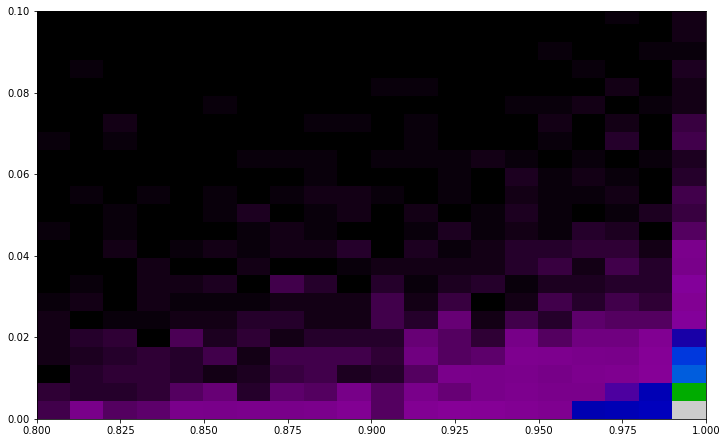

In [183]:
fig,ax = plt.subplots(1,1,figsize=(12,7.5))
xy = ax.hist2d(cl,sp_var,bins=100,cmap='nipy_spectral')
ax.set_xlim(0.8,1)
ax.set_ylim(0,0.1)
plt.colorbar()

Text(0.5, 1.0, 'räumliche Variabilität der HACI-Tacks in einem 51-px-x-51-px-Ausschnitts\num den HACI-CI-Punkt zum Auslösezeitpunkt')

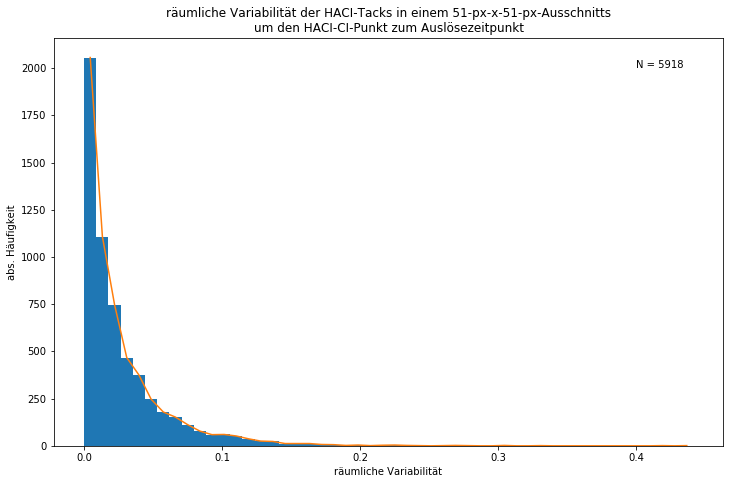

In [156]:
fig,ax = plt.subplots(1,1,figsize=(12,7.5))
n, x , _ = ax.hist(list(spatial_variance.values()),bins=50)
bin_centres =  0.5*(x[1:]+x[:-1])
ax.set_xlabel(u"räumliche Variabilität")
ax.set_ylabel(u"abs. Häufigkeit")
ax.plot(bin_centres,n)
ax.text(0.4,2000,"N = {}".format(len(cloudiness.keys())))
ax.set_title(u"räumliche Variabilität der HACI-Tacks in einem 51-px-x-51-px-Ausschnitts\num den HACI-CI-Punkt zum Auslösezeitpunkt")

In [235]:
valid_cases = np.array(list(spatial_variance.keys()))[np.where(np.array(list(spatial_variance.values()))>0.05)]

In [236]:
sp = np.array(list(spatial_variance.values()))[np.where(np.array(list(spatial_variance.values()))>0.05)]

In [237]:
cl = np.array(list(cloudiness.values()))[np.where(np.array(list(spatial_variance.values()))>0.05)]

In [238]:
case_df = pd.DataFrame({'case_id':valid_cases,
                        'spatial_variance':sp,
                        'cloudiness':cl})

In [221]:
case_df

case_id  spatial_variance  cloudiness
0    2008-05-29 19:55:00+00:00_2372          0.092218    0.946175
1    2008-05-30 12:25:00+00:00_1321          0.064793    0.081123
2    2008-05-30 12:25:00+00:00_1323          0.069817    0.081123
3    2008-05-30 21:50:00+00:00_2760          0.050082    0.152634
4    2008-05-31 14:05:00+00:00_1418          0.071209    0.447905
..                              ...               ...         ...
929   2015-09-01 11:45:00+00:00_559          0.106360    0.930027
930   2015-09-01 13:50:00+00:00_873          0.064849    0.955017
931   2015-09-02 09:50:00+00:00_378          0.050993    0.606690
932  2015-09-14 16:10:00+00:00_1947          0.098328    0.997309
933  2015-09-18 20:40:00+00:00_1224          0.052078    0.706267

[934 rows x 3 columns]

In [240]:
valid_cases = case_df[case_df.cloudiness < 0.8]

In [242]:
valid_cases.to_csv("/vols/satellit/home/lenk/proj/2019-01_trackingstudie/data/valid_cases.csv",index=False,float_format="%.2f")

In [132]:
import pickle

In [55]:
pickle.dump( cloudiness, open( "/vols/satellit/home/lenk/proj/2019-01_trackingstudie/data/cloudiness.p", "wb" ) )

In [152]:
pickle.dump( spatial_variance, open( "/vols/satellit/home/lenk/proj/2019-01_trackingstudie/data/spatial_variance.p", "wb" ) )

In [56]:
cloudiness = pickle.load(open("/vols/satellit/home/lenk/proj/2019-01_trackingstudie/data/cloudiness.p","rb"))

Text(0.5, 1.0, 'Bewölkungsgrad des 51-px-x-51-px-Ausschnitts\num den HACI-CI-Punkt zum Auslösezeitpunkt')

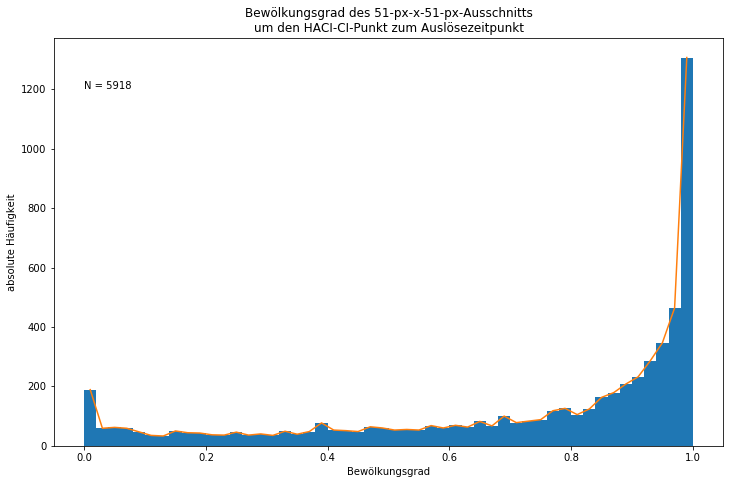

In [84]:
fig,ax = plt.subplots(1,1,figsize=(12,7.5))
n, x , _ = ax.hist(list(cloudiness.values()),bins=50)
bin_centres =  0.5*(x[1:]+x[:-1])
ax.set_xlabel(u"Bewölkungsgrad")
ax.set_ylabel(u"absolute Häufigkeit")
ax.plot(bin_centres,n)
ax.text(0,1200,"N = {}".format(len(cloudiness.keys())))
ax.set_title(u"Bewölkungsgrad des 51-px-x-51-px-Ausschnitts\num den HACI-CI-Punkt zum Auslösezeitpunkt")

In [79]:
from scipy import stats

((array([-2.21154155, -1.84175131, -1.62365924, -1.46329903, -1.33363779,
         -1.22318558, -1.1259265 , -1.03829303, -0.95798431, -0.88342315,
         -0.81347686, -0.74730127, -0.68424773, -0.62380483, -0.5655602 ,
         -0.50917466, -0.45436405, -0.40088629, -0.34853176, -0.29711609,
         -0.24647455, -0.19645772, -0.14692788, -0.09775611, -0.0488197 ,
          0.        ,  0.0488197 ,  0.09775611,  0.14692788,  0.19645772,
          0.24647455,  0.29711609,  0.34853176,  0.40088629,  0.45436405,
          0.50917466,  0.5655602 ,  0.62380483,  0.68424773,  0.74730127,
          0.81347686,  0.88342315,  0.95798431,  1.03829303,  1.1259265 ,
          1.22318558,  1.33363779,  1.46329903,  1.62365924,  1.84175131,
          2.21154155]),
  array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
         0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
         0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
         0.

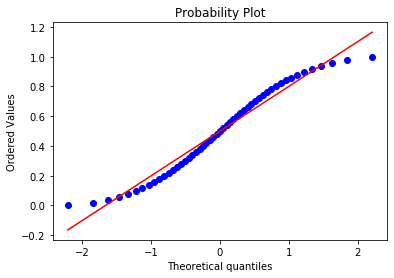

In [80]:
stats.probplot(x, plot=plt)

In [93]:
np.quantile(np.array(list(cloudiness.values())),[0.25,0.5,0.75])

array([0.54757785, 0.86812764, 0.97385621])

Text(0.9438562091503268, 800, 'q$_\\mathrm{75}$')

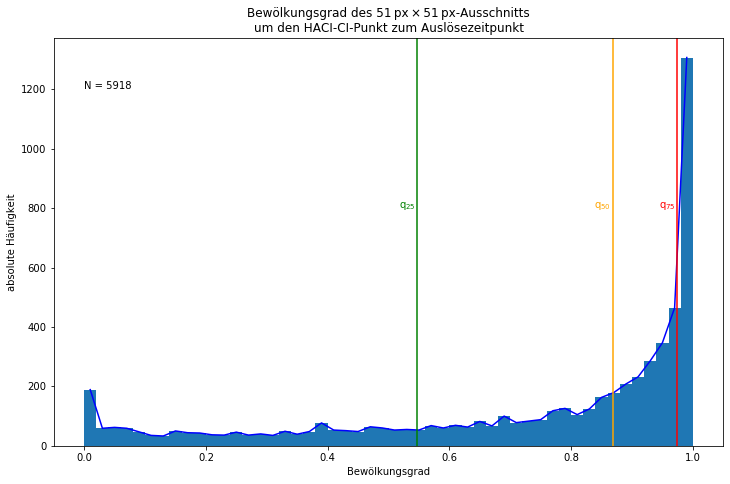

In [111]:
fig,ax = plt.subplots(1,1,figsize=(12,7.5))
n, x , _ = ax.hist(list(cloudiness.values()),bins=50)
bin_centres =  0.5*(x[1:]+x[:-1])
ax.set_xlabel(u"Bewölkungsgrad")
ax.set_ylabel(u"absolute Häufigkeit")
ax.plot(bin_centres,n,color='b')
ax.text(0,1200,"N = {}".format(len(cloudiness.keys())))
ax.set_title(u"Bewölkungsgrad des 51\u202Fpx\u202F×\u202F51\u202Fpx-Ausschnitts\num den HACI-CI-Punkt zum Auslösezeitpunkt")
ax.axvline(np.quantile(np.array(list(cloudiness.values())),0.25),color='g')
ax.text(np.quantile(np.array(list(cloudiness.values())),0.25)-0.03,800,r'q$_\mathrm{25}$',color='g')
ax.axvline(np.quantile(np.array(list(cloudiness.values())),0.5),color='orange')
ax.text(np.quantile(np.array(list(cloudiness.values())),0.5)-0.03,800,r'q$_\mathrm{50}$',color='orange')
ax.axvline(np.quantile(np.array(list(cloudiness.values())),0.75),color='r')
ax.text(np.quantile(np.array(list(cloudiness.values())),0.75)-0.03,800,r'q$_\mathrm{75}$',color='r')

In [243]:
from sklearn.cluster import AgglomerativeClustering

In [244]:
X = []

for i, case in valid_cases.iterrows():
    X.append([case.spatial_variance,case.cloudiness])

In [245]:
clustering = AgglomerativeClustering(n_clusters=4,linkage='ward').fit(np.array(X))

In [246]:
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [247]:
clustering.labels_

array([1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 2, 0, 3, 3, 1, 1,
       1, 3, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 2, 2, 0, 3, 0, 0, 2, 2, 0, 0,
       0, 0, 3, 1, 0, 0, 0, 3, 2, 3, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 3, 3, 3, 0, 2, 3, 2, 2, 0,
       0, 2, 2, 2, 0, 0, 0, 0, 2, 3, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2,
       1, 1, 1, 0, 0, 2, 1, 3, 1, 1, 3, 2, 3, 3, 1, 1, 1, 0, 2, 2, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 1, 0, 2, 3, 0, 3, 0, 1, 2, 0, 0, 0, 0, 2, 3, 0, 0, 0,
       0, 0, 0, 0, 3, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1,
       1, 1, 1, 1, 3, 2, 2, 0, 0, 3, 3, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 1, 3, 2, 0,

In [248]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [249]:
Z = linkage(X, 'ward')

In [250]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.7717046219496848

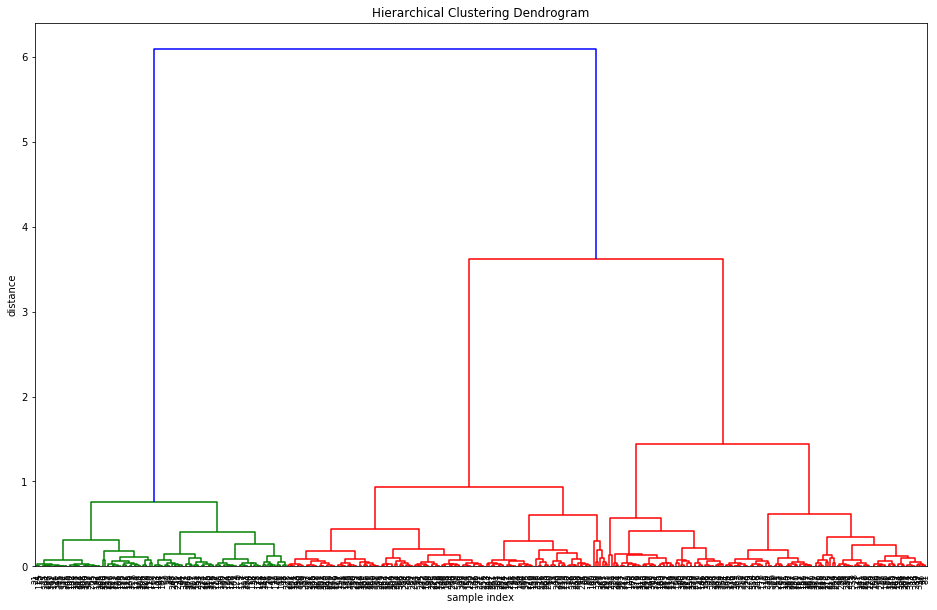

In [251]:
plt.figure(figsize=(16, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [252]:
Z[-4:,2]

array([0.93244229, 1.44231787, 3.62284216, 6.09514587])

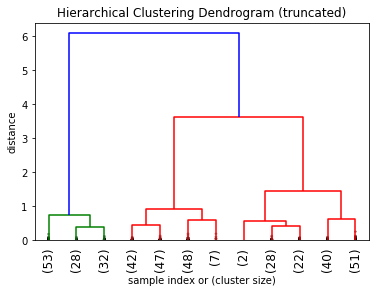

In [253]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [254]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

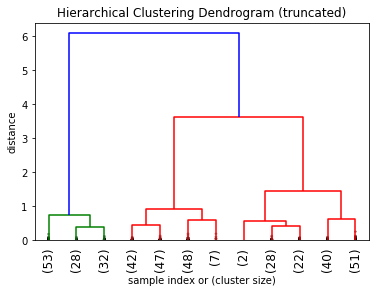

In [255]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [256]:
from scipy.cluster.hierarchy import fcluster
max_d = 2
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 2, 2, 2, 3, 3, 2, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 2, 3, 3, 1, 1,
       1, 3, 3, 1, 2, 2, 2, 3, 1, 2, 1, 1, 3, 3, 2, 3, 2, 2, 3, 3, 2, 2,
       2, 2, 3, 1, 2, 2, 2, 3, 3, 3, 1, 1, 2, 2, 1, 3, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2,
       2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3,
       1, 1, 1, 2, 2, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 1, 2, 3, 3, 2, 3, 2, 1, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 3, 1, 3, 3, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 3, 2, 1,
       1, 1, 1, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 1, 3, 3, 2,

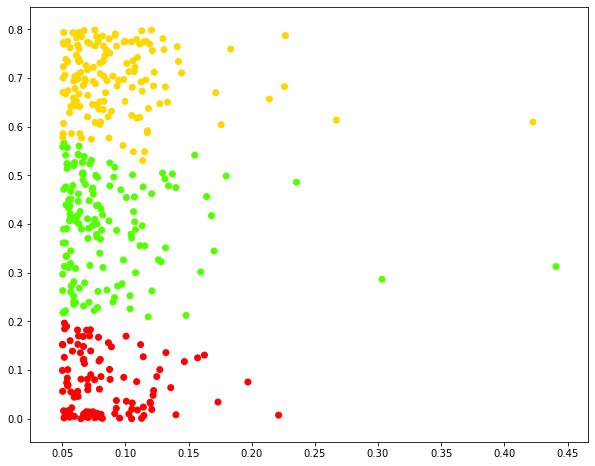

In [267]:
plt.figure(figsize=(10, 8))
plt.scatter(valid_cases.spatial_variance,valid_cases.cloudiness ,c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

In [268]:
valid_cases.iloc[0]

case_id             2008-05-30 12:25:00+00:00_1321
spatial_variance                         0.0647927
cloudiness                               0.0811226
Name: 1, dtype: object

In [270]:
case = valid_cases.iloc[0]

In [271]:
case.case_id

'2008-05-30 12:25:00+00:00_1321'

In [278]:
date = case.case_id.split("_")[0]
cid = int(case.case_id.split("_")[1])

In [277]:
cid

'1321'

In [279]:
case_data = haci_objects[(haci_objects.date==date) & (haci_objects.id==cid)]

In [280]:
case_data

date   time    id  flags   t0   t1  l00  l01  c00  \
64 2008-05-30 12:25:00+00:00  12:25  1321      0  149  155   54   58  690   

    c01  ...  area_max  darea  l0_msg_eu  c0_msg_eu  l1_msg_eu  c1_msg_eu  \
64  694  ...       306    290        230        557        228        562   

    l00_msg_eu  c00_msg_eu  l01_msg_eu  c01_msg_eu  
64         231         561         230         562  

[1 rows x 26 columns]

In [294]:
t = pd.Timestamp(case_data.date.values[0]).to_pydatetime()

In [296]:
test = lsd.load_satellite_data(t,'IR_108')

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2008/05/30/msg?-sevi-20080530t1225z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit1205475455/H-000-MSG1__-MSG1_RSS____-IR_108___-000007___-200805301225-__
... reading  /tmp/hrit1205475455/H-000-MSG1__-MSG1_RSS____-IR_108___-000008___-200805301225-__

Combine segments

Do calibration


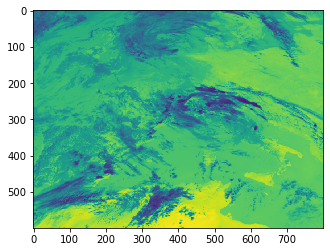

In [303]:
plt.imshow(test)

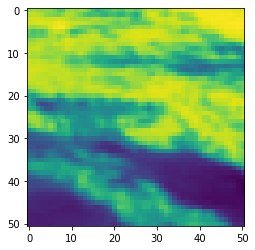

In [302]:
plt.imshow(cutout_box(test,case_data.l0_msg_eu.values[0],case_data.c0_msg_eu.values[0],51))

In [ ]:
test = lsd.load_satellite_data

In [306]:
case_data.l00_msg_eu.values[0] + (case_data.l01_msg_eu.values[0] - case_data.l00_msg_eu.values[0]) // 2

230

In [307]:
case_data.l0_msg_eu

64    230
Name: l0_msg_eu, dtype: int64

In [311]:
case_date = case.case_id.split("_")[0]
case_id = int(case.case_id.split("_")[1])

start_time = pd.Timestamp(case_data.date.values[0]).to_pydatetime()

case_data =  haci_objects[(haci_objects.date==case_date) & (haci_objects.id==case_id)]

start_row = case_data.l00_msg_eu.values[0] + (case_data.l01_msg_eu.values[0] - case_data.l00_msg_eu.values[0]) // 2
start_col = case_data.c00_msg_eu.values[0] + (case_data.c01_msg_eu.values[0] - case_data.c00_msg_eu.values[0]) // 2

time_steps = pd.date_range(start = start_time - pd.Timedelta("30min"),
                           end = start_time + pd.Timedelta("30min"),
                           freq = "5min")

In [313]:
sat_data = {ch:[] for ch in satellite_fields}

for i,t in enumerate(time_steps):
    sat_obs = lsd.load_satellite_data_multichannel(t.to_pydatetime(),channel_list = msevi_config._narrow_channels + ['HRV'])

    for k in ['CT','CTTH_HEIGHT','CMa']:
        sat_data[k].append(mst.get_nwcsaf_prod(k,t.to_pydatetime(),calibrate=True))

    for k in msevi_config._narrow_channels + ['HRV']:
        if k == 'HRV':
            cth_hires = gi.make_hrv_upscaling(sat_data['CTTH_HEIGHT'][i])
            px_corr = go.parallax_correct_msg(sat_obs[k],hlon,hlat,cth_hires,'hrv','eu','rss',3)
        else:
            px_corr = go.parallax_correct_msg(sat_obs[k],slon,slat,sat_data['CTTH_HEIGHT'][i],'std','eu','rss',3)

        sat_data[k].append(px_corr)
        
        

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2008/05/30/msg?-sevi-20080530t1155z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-VIS006___-000007___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-VIS006___-000008___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-VIS008___-000007___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-VIS008___-000008___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-IR_016___-000007___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-IR_016___-000008___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-200805301155-__
... reading  /tmp/hrit5059268787/H-000-MSG1__-MSG1_RSS____-WV_062___-000007_

... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-VIS008___-000007___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-VIS008___-000008___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-IR_016___-000007___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-IR_016___-000008___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-WV_062___-000007___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-WV_062___-000008___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-WV_073___-000007___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1_RSS____-WV_073___-000008___-200805301210-__
... reading  /tmp/hrit3566263665/H-000-MSG1__-MSG1

... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-WV_062___-000007___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-WV_062___-000008___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-WV_073___-000007___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-WV_073___-000008___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-IR_087___-000007___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-IR_087___-000008___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-IR_097___-000007___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1_RSS____-IR_097___-000008___-200805301225-__
... reading  /tmp/hrit3354599181/H-000-MSG1__-MSG1

... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-WV_062___-000007___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-WV_062___-000008___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-WV_073___-000007___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-WV_073___-000008___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-IR_087___-000007___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-IR_087___-000008___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-IR_097___-000007___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-IR_097___-000008___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-IR_108___-000007___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1_RSS____-IR_108___-000008___-200805301240-__
... reading  /tmp/hrit8994956275/H-000-MSG1__-MSG1

... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_087___-000007___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_087___-000008___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_097___-000007___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_097___-000008___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_108___-000007___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_108___-000008___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_120___-000007___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_120___-000008___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_134___-000007___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1_RSS____-IR_134___-000008___-200805301255-__
... reading  /tmp/hrit8790739666/H-000-MSG1__-MSG1

In [350]:
tracking_base = []
    
for sd in sat_data['IR_108']:
    cutout = cutout_box(sd,start_row,start_col,51)
    tracking_base.append(cutout)

shift = {}
for i, sd in enumerate(tracking_base):
    try:
        source = sd.copy()
        source[source>273] = 0
        source[source<=273] = 1
        
        target = tracking_base[i+1].copy()
        target[target>273] = 0
        target[target<=273] = 1
        
        s, _, _ = register_translation(source,target,100)

        row_shift = int(np.rint(s[0]))
        col_shift = int(np.rint(s[1]))
        shift["{}_{}".format(i,i+1)] = np.array([row_shift, col_shift])
    except:
        continue

In [351]:
shift

{'0_1': array([-1, -1]),
 '1_2': array([-1, -1]),
 '2_3': array([-1, -1]),
 '3_4': array([-1, -1]),
 '4_5': array([-1, -1]),
 '5_6': array([-1, -1]),
 '6_7': array([-1, -1]),
 '7_8': array([-1, -1]),
 '8_9': array([-1, -1]),
 '9_10': array([-1, -1]),
 '10_11': array([-1, -1]),
 '11_12': array([-1, -1])}

In [352]:
track = [(7, start_row, start_col)]
start_time_index = 7

In [353]:
previous_row = start_row
previous_col = start_col
previous_index = start_time_index

time = [previous_index]
rows = [previous_row]
cols = [previous_col]
for current_index in range(start_time_index-1,0,-1):
    s = shift['{}_{}'.format(current_index,previous_index)]
    
    new_row = previous_row - s[0]
    new_col = previous_col - s[1]

    time.insert(0,current_index)
    rows.insert(0,new_row)
    cols.insert(0,new_col)
    
    previous_row = new_row
    previous_col = new_col
    previous_index = current_index

previous_row = start_row
previous_col = start_col
previous_index = start_time_index    
for current_index in range(start_time_index+1,13,1):
    shift = shifts['{}_{}'.format(previous_index,current_index)]
    
    new_row = previous_row + s[0]
    new_col = previous_col + s[1]

    
    time.append(current_index)
    rows.append(new_row)
    cols.append(new_col)
    
    previous_row = new_row
    previous_col = new_col
    previous_index = current_index

In [354]:
time,rows, cols

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225],
 [567, 566, 565, 564, 563, 562, 561, 560, 559, 558, 557, 556])

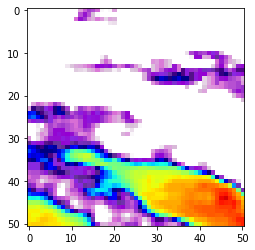

In [334]:
plt.imshow(np.ma.masked_greater(tracking_base[7],273),vmin=210,vmax=300,cmap=emap)

In [359]:
track = pd.DataFrame({'time_index':time,
                          'row_index': rows,
                          'column_index': cols})

In [363]:
sat_data_cutouts = {ch:[] for ch in satellite_fields}

for i,t in enumerate(time_steps):
    for k in list(sat_data.keys()):
        try:
            cutout = cutout_box(sat_data[k][i],track.iloc[i].row_index,track.iloc[i].column_index,51)
            sat_data_cutouts[k].append(cutout)
        except Exception as e:
            print("Fehler {}.".format(e))

Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.
Fehler single positional indexer is out-of-bounds.


In [364]:
sat_data_cutouts

{'VIS006': [array([[0.13917488, 0.14149446, 0.12989656, ..., 0.08582451, 0.08002556,
          0.08814409],
         [0.10322137, 0.12641719, 0.12061823, ..., 0.08350493, 0.08582451,
          0.09162346],
         [0.10554095, 0.10902033, 0.10670074, ..., 0.08466472, 0.0869843 ,
          0.0869843 ],
         ...,
         [0.73066814, 0.73878667, 0.74342584, ..., 0.51030791, 0.55206037,
          0.64484363],
         [0.75270416, 0.75386395, 0.7608227 , ..., 0.37461239, 0.34445784,
          0.42216381],
         [0.75270416, 0.74574542, 0.74574542, ..., 0.58105514, 0.51958623,
          0.39084946]]),
  array([[0.1368553 , 0.11713886, 0.15077279, ..., 0.07886577, 0.08234514,
          0.07886577],
         [0.11713886, 0.11713886, 0.11365949, ..., 0.08582451, 0.08582451,
          0.08002556],
         [0.10670074, 0.10322137, 0.10438116, ..., 0.08118535, 0.08350493,
          0.08466472],
         ...,
         [0.72370939, 0.73878667, 0.74690521, ..., 0.63904467, 0.68079714,
   

In [416]:
def write_data2netcdf(sat_data,filename,time_data):
    data_dict = {}
    
    for f in satellite_fields:
        if f == 'HRV':
            data_dict[f] = (['time','hx','hy'], np.array(sat_data[f]))
        else:
            data_dict[f] = (['time','x','y'], np.array(sat_data[f]))
    #data_dict = {f:(['time','x','y'], np.array(sat_data[f])) for f in satellite_fields}
    
    ds = xr.Dataset(data_dict,
                    coords={'time': time_data[:-1],
                            'lon': (['time','x', 'y'], sat_data['lon']),
                            'lat': (['time','x', 'y'], sat_data['lat']),
                            'hlon': (['time','hx','hy'], sat_data['hlon']),
                            'hlon': (['time','hx','hy'], sat_data['hlon'])})
    
    ds.attrs['title'] = "Data cutout for ".format(time_data[0].strftime("%Y%m%d"))
    ds.attrs['institution'] = "Leibniz Institute for Tropospheric Research"
    ds.attrs['contact_person'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['processing_time'] = pd.Timestamp.now().strftime("%Y%m%dT%H:%M:%S")
    ds.attrs['author'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['license'] = "For non-commercial use only."
    ds.attrs['source'] = "EUMETSAT MSG SEVIRI level 1.5 data and NWCSAF v2013 products"
    ds.attrs['history'] = "Data cutout araound HACI object at CI time and CI time - 30 min and + 30 min."
    ds.attrs['summary'] = "MSG data and NWCSAF products for HACI object."
    ds.attrs['region_id'] = "MSG eu"
    ds.attrs['spatial_resolution'] = "3 km x 6km"
    ds.attrs['gdal_projection'] = '+proj=stere +lat_0=90 +lat_ts=60 +lon_0=10 '+\
                                  '+x_0=0 +y_0=0 +a=6370.040 +b=6370.040 +units=km'
    
    encoding = {var: {'complevel':9,
                      'zlib':'True',
                      '_FillValue': -99999 } for var in ds.data_vars}

    ds.to_netcdf(filename,encoding=encoding)

    nachricht = "Daten unter %s gespeichert.\n" % filename
    print(nachricht)
    return  

In [413]:
target_path = "/vols/satellit/home/lenk/proj/2019-01_trackingstudie/data/lagrangian_tracks/"

In [414]:
from analysis_tools import make_hrv_upscaling as mhu

In [ ]:
for i, case in valid_cases.iterrows():
    # load case cutout coordinates
    case_date = case.case_id.split("_")[0]
    case_id = int(case.case_id.split("_")[1])
    
    start_time = pd.Timestamp(case_data.date.values[0]).to_pydatetime()

    case_data =  haci_objects[(haci_objects.date==case_date) & (haci_objects.id==case_id)]
   
    start_row = case_data.l00_msg_eu.values[0] + (case_data.l01_msg_eu.values[0] - case_data.l00_msg_eu.values[0]) // 2
    start_col = case_data.c00_msg_eu.values[0] + (case_data.c01_msg_eu.values[0] - case_data.c00_msg_eu.values[0]) // 2
    
    time_steps = pd.date_range(start = start_time - pd.Timedelta("30min"),
                               end = start_time + pd.Timedelta("30min"),
                               freq = "5min")
    
    sat_data = {ch:[] for ch in satellite_fields}

    for i,t in enumerate(time_steps):
        sat_obs = lsd.load_satellite_data_multichannel(t.to_pydatetime(),channel_list = msevi_config._narrow_channels + ['HRV'])

        for k in ['CT','CTTH_HEIGHT','CMa']:
            sat_data[k].append(mst.get_nwcsaf_prod(k,t.to_pydatetime(),calibrate=True))

        for k in msevi_config._narrow_channels + ['HRV']:
            if k == 'HRV':
                cth_hires = gi.make_hrv_upscaling(sat_data['CTTH_HEIGHT'][i])
                px_corr = go.parallax_correct_msg(sat_obs[k],hlon,hlat,cth_hires,'hrv','eu','rss',3)
            else:
                px_corr = go.parallax_correct_msg(sat_obs[k],slon,slat,sat_data['CTTH_HEIGHT'][i],'std','eu','rss',3)

            sat_data[k].append(px_corr)
            
    tracking_base = []
    
    for sd in sat_data['IR_108']:
        cutout = cutout_box(sd,start_row,start_col,51)
        tracking_base.append(cutout)

    shift = {}
    for i, sd in enumerate(tracking_base):
        try:
            source = sd.copy()
            source[source>273] = 0
            source[source<=273] = 1

            target = tracking_base[i+1].copy()
            target[target>273] = 0
            target[target<=273] = 1

            s, _, _ = register_translation(source,target,100)

            row_shift = int(np.rint(s[0]))
            col_shift = int(np.rint(s[1]))
            shift["{}_{}".format(i,i+1)] = np.array([row_shift, col_shift])
        except:
            continue
    
    start_time_index = 7
    previous_row = start_row
    previous_col = start_col
    previous_index = start_time_index

    time = [previous_index]
    rows = [previous_row]
    cols = [previous_col]
    
    for current_index in range(start_time_index-1,0,-1):
        s = shift['{}_{}'.format(current_index,previous_index)]

        new_row = previous_row - s[0]
        new_col = previous_col - s[1]

        time.insert(0,current_index)
        rows.insert(0,new_row)
        cols.insert(0,new_col)

        previous_row = new_row
        previous_col = new_col
        previous_index = current_index

    previous_row = start_row
    previous_col = start_col
    previous_index = start_time_index 
    
    for current_index in range(start_time_index+1,13,1):
        shift = shifts['{}_{}'.format(previous_index,current_index)]

        new_row = previous_row + s[0]
        new_col = previous_col + s[1]


        time.append(current_index)
        rows.append(new_row)
        cols.append(new_col)

        previous_row = new_row
        previous_col = new_col
        previous_index = current_index
        
    track = pd.DataFrame({'time_index':time,
                          'row_index': rows,
                          'column_index': cols})
    
    id_time = case_date.replace("-", "").replace(" ","T").replace(":","").replace("00+0000","")
    track.to_csv("{}track_data/{}_{}.csv".format(target_path,id_time,case_id),
                index=False)
    
    sat_data_cutouts = {ch:[] for ch in list(sat_data.keys()) + ['lon','lat','hlon','hlat']}
    
    for i,t in enumerate(time_steps):
        try:
            slon_cutout = cutout_box(slon,track.iloc[i].row_index,track.iloc[i].column_index,51)
            slat_cutout = cutout_box(slat,track.iloc[i].row_index,track.iloc[i].column_index,51)
            
            hlon_cutout = mhu.make_hrv_upscaling(slon_cutout)
            hlat_cutout = mhu.make_hrv_upscaling(slat_cutout)

            sat_data_cutouts['lon'].append(slon_cutout)
            sat_data_cutouts['lat'].append(slat_cutout)
            sat_data_cutouts['hlon'].append(hlon_cutout)
            sat_data_cutouts['hlat'].append(hlat_cutout)

            for k in list(sat_data.keys()):
                try:
                    if k == 'HRV':
                        fac = 3
                    else:
                        fac = 1

                    cutout = cutout_box(sat_data[k][i],
                                        track.iloc[i].row_index*fac,
                                        track.iloc[i].column_index*fac,
                                        51*fac)
                    
                    sat_data_cutouts[k].append(cutout)
                except Exception as e:
                    print("Fehler {}.".format(e))
        except Exception as e:
            print("Fehler {}.".format(e))
                
    write_data2netcdf(sat_data_cutouts,"{}field_data/{}_{}.nc".format(target_path,id_time,case_id),time_steps)
    print("Trackdaten gespeichert.")
    update_progress(i / len(valid_cases.cloudiness))

Fortschritt: [####################] 100.0%
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2009/06/09/msg?-sevi-20090609t2115z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-VIS006___-000007___-200906092115-__
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-VIS006___-000008___-200906092115-__
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-VIS008___-000007___-200906092115-__
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-VIS008___-000008___-200906092115-__
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-IR_016___-000007___-200906092115-__
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-IR_016___-000008___-200906092115-__
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-200906092115-__
... reading  /tmp/hrit6438255551/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-200906092115-__
... reading  /tmp/hrit6438255551/

... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-VIS006___-000007___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-VIS006___-000008___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-VIS008___-000007___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-VIS008___-000008___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-IR_016___-000007___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-IR_016___-000008___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-WV_062___-000007___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1_RSS____-WV_062___-000008___-200906092130-__
... reading  /tmp/hrit5348441071/H-000-MSG1__-MSG1

... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-VIS008___-000007___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-VIS008___-000008___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-IR_016___-000007___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-IR_016___-000008___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-WV_062___-000007___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-WV_062___-000008___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-WV_073___-000007___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1_RSS____-WV_073___-000008___-200906092145-__
... reading  /tmp/hrit9813586991/H-000-MSG1__-MSG1

... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-WV_062___-000007___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-WV_062___-000008___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-WV_073___-000007___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-WV_073___-000008___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-IR_087___-000007___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-IR_087___-000008___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-IR_097___-000007___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-IR_097___-000008___-200906092200-__
... reading  /tmp/hrit379967026/H-000-MSG1__-MSG1_RSS____-IR